In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras import Sequential, layers
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os
import time
import random
import imghdr
import sys

sys.path.append("/content/drive/MyDrive/personal_assistant/")
from helper_scripts.helper_functions import *

# Getting familiar with the data

In [ ]:
FACE_IMAGES_DIR = "/content/drive/MyDrive/personal_assistant/data/face_images"
TRAIN_DIR = "/content/drive/MyDrive/personal_assistant/data/face_images/train/"
TEST_DIR = "/content/drive/MyDrive/personal_assistant/data/face_images/test/"
IMG_SIZE = (224,224)

In [ ]:
# Remove all unnecessery files from all folders
for i in os.listdir(FACE_IMAGES_DIR):
    if i == ".DS_Store":
        os.remove(os.path.join(FACE_IMAGES_DIR, i))
    else:    
        for j in os.listdir(os.path.join(FACE_IMAGES_DIR, i)):
            if j == ".DS_Store":
                os.remove(os.path.join(FACE_IMAGES_DIR, i,j))
            else:
                for k in os.listdir(os.path.join(FACE_IMAGES_DIR, i, j)):
                    if k == ".DS_Store":
                        os.remove(os.path.join(FACE_IMAGES_DIR, i,j, k))

In [ ]:
# How many folders and files are there?
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/personal_assistant/data/face_images"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/personal_assistant/data/face_images'.
There are 5 directories and 0 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train'.
There are 0 directories and 47 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train/sasha'.
There are 0 directories and 47 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train/illia'.
There are 0 directories and 83 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train/nikita'.
There are 0 directories and 45 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train/anna'.
There are 0 directories and 178 images in '/content/drive/MyDrive/personal_assistant/data/face_images/train/other_people'.
There are 5 directories and 0 images in '/content/drive/MyDrive/personal_assistant/data/face_images/test'.
There are 0 directories and 18 images in '/content/drive/MyDrive/personal_assistant/data/face_images

In [ ]:
# Deleting images with an inappropriate file type
proper_files = ["bmp", "png", "jpeg", "jpg"]
for i in os.listdir("/content/drive/MyDrive/personal_assistant/data/face_images/test/other_people"):
    if imghdr.what(f"/content/drive/MyDrive/personal_assistant/data/face_images/test/other_people/{i}") not in proper_files:
        print(f"Removing image: {i}")
        os.remove(f"/content/drive/MyDrive/personal_assistant/data/face_images/test/other_people/{i}")


In [ ]:
len(os.listdir("/content/drive/MyDrive/personal_assistant/data/face_images/train/other_people")), len(os.listdir("/content/drive/MyDrive/personal_assistant/data/face_images/test/other_people"))

(178, 61)

In [ ]:
train_data_in = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode="categorical",
    image_size=IMG_SIZE,
    shuffle=True,
    batch_size=16
)

test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    label_mode="categorical",
    batch_size=16
)


Found 400 files belonging to 5 classes.
Found 129 files belonging to 5 classes.


In [ ]:
class_names = train_data_in.class_names

### Split the data into train and val sets

In [ ]:
train_size = int(len(train_data_in) * 0.8)
val_size = len(train_data_in) - train_size

train_data = train_data_in.take(train_size).shuffle(train_size).cache().prefetch(tf.data.AUTOTUNE)
val_data = train_data_in.skip(train_size).shuffle(val_size).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
train_labels_one_hot = np.concatenate([y for x, y in train_data], axis=0)
train_labels = tf.argmax(train_labels_one_hot,1)
train_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 4, 0, 3, 1, 2, 3, 3, 2, 4])>

In [ ]:
val_labels_one_hot = np.concatenate([y for x, y in val_data], axis=0)
val_labels = tf.argmax(val_labels_one_hot,1)
val_labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 3, 3, 2, 2, 1, 2, 1, 4])>

# Build a baseline model

The first model is going to be a simple Softmax Regression in a form of a Neural Network

In [ ]:
# Create a model
baseline_model = Sequential([
    layers.Input(shape=IMG_SIZE+(3,)),
    layers.Rescaling(1 / 255.),
    layers.Flatten(),
    layers.Dense(5, activation="softmax")
])

# Compile the model
baseline_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 5)                 752645    
                                                                 
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#plot_model(baseline_model, to_file="../models/model_architectures/baseline_model.jpg", show_shapes=True)

In [ ]:
hist0 = baseline_model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=(val_data),
    validation_steps=len(val_data)
)

Epoch 1/10
20/20 [==============================] - 3s 58ms/step - loss: 27.3484 - accuracy: 0.5063 - val_loss: 7.8186 - val_accuracy: 0.7750
Epoch 2/10
20/20 [==============================] - 0s 24ms/step - loss: 8.9966 - accuracy: 0.7281 - val_loss: 6.1195 - val_accuracy: 0.8375
Epoch 3/10
20/20 [==============================] - 0s 20ms/step - loss: 4.6632 - accuracy: 0.8000 - val_loss: 2.9736 - val_accuracy: 0.8250
Epoch 4/10
20/20 [==============================] - 0s 19ms/step - loss: 1.8603 - accuracy: 0.8500 - val_loss: 2.1173 - val_accuracy: 0.8125
Epoch 5/10
20/20 [==============================] - 0s 21ms/step - loss: 2.2673 - accuracy: 0.8031 - val_loss: 1.8424 - val_accuracy: 0.8750
Epoch 6/10
20/20 [==============================] - 0s 21ms/step - loss: 1.4387 - accuracy: 0.8938 - val_loss: 2.9128 - val_accuracy: 0.7250
Epoch 7/10
20/20 [==============================] - 0s 20ms/step - loss: 1.7269 - accuracy: 0.8687 - val_loss: 1.4293 - val_accuracy: 0.8875
Epoch 8/10
2

In [ ]:
baseline_model.evaluate(val_data)

5/5 [==============================] - 0s 7ms/step - loss: 5.4154 - accuracy: 0.6250


[5.415352821350098, 0.625]

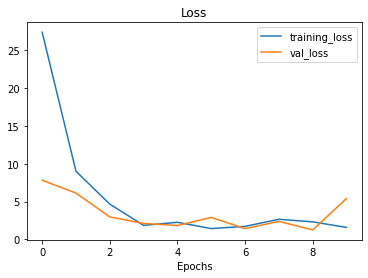

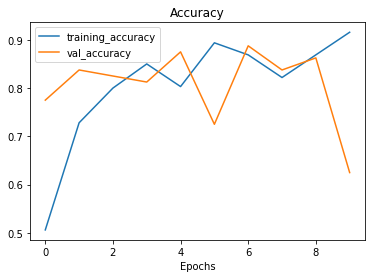

In [ ]:
plot_loss_curves(hist0)

In [ ]:
baseline_results = calculate_results(val_data, baseline_model)
baseline_results

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1
0,68.75,0.861111,0.6875,0.699405
1,56.25,0.885417,0.5625,0.572024
2,56.25,0.822917,0.5625,0.589286
3,75.00,0.772917,0.7500,0.713889
4,56.25,0.843750,0.5625,0.567857


## Adding data augmentation

In [ ]:
data_aug = Sequential([
    layers.Rescaling(1./255),
    layers.RandomHeight(0.4),
    layers.RandomWidth(0.4),
    layers.RandomFlip(mode="horizontal")
])

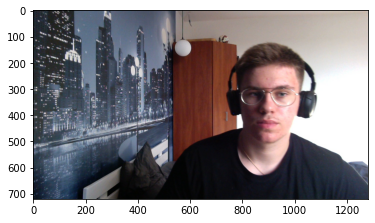

In [ ]:
test_img = "/content/drive/MyDrive/personal_assistant/data/face_images/train/nikita/18:35:27.jpeg"
test_img = mpimg.imread(test_img)
plt.imshow(test_img);

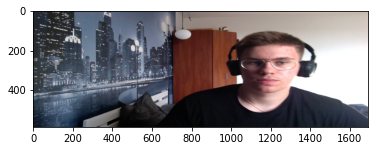

In [ ]:
plt.imshow(data_aug(test_img));

## Creating a model with Conv2D layers

In [ ]:
# Create a model
model1 = Sequential([
    layers.Input(shape=IMG_SIZE+(3,)),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPool2D(),

    layers.Conv2D(64, 4, activation="relu"),
    layers.MaxPool2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(5)
])

# Compile the model
model1.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dense_1 (Dense)             (None, 128)              

In [ ]:
# Fit the model
hist1 = model1.fit(
    train_data,
    epochs=10,
    validation_data=(val_data)
)

Epoch 1/10
20/20 [==============================] - 35s 2s/step - loss: 302.0637 - accuracy: 0.5875 - val_loss: 0.2940 - val_accuracy: 0.9125
Epoch 2/10
20/20 [==============================] - 40s 2s/step - loss: 0.3634 - accuracy: 0.9062 - val_loss: 0.1414 - val_accuracy: 0.9625
Epoch 3/10
20/20 [==============================] - 34s 2s/step - loss: 0.1445 - accuracy: 0.9656 - val_loss: 0.0866 - val_accuracy: 0.9750
Epoch 4/10
20/20 [==============================] - 37s 2s/step - loss: 0.0473 - accuracy: 0.9906 - val_loss: 0.3680 - val_accuracy: 0.9375
Epoch 5/10
20/20 [==============================] - 34s 2s/step - loss: 0.0344 - accuracy: 0.9937 - val_loss: 0.0847 - val_accuracy: 0.9750
Epoch 6/10
20/20 [==============================] - 34s 2s/step - loss: 0.0953 - accuracy: 0.9844 - val_loss: 0.1081 - val_accuracy: 0.9625
Epoch 7/10
20/20 [==============================] - 36s 2s/step - loss: 0.1084 - accuracy: 0.9844 - val_loss: 0.0798 - val_accuracy: 0.9625
Epoch 8/10
20/20 [

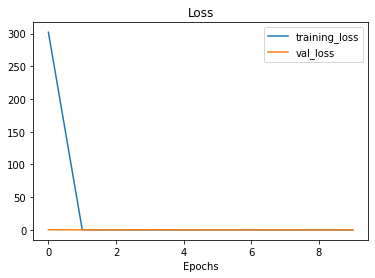

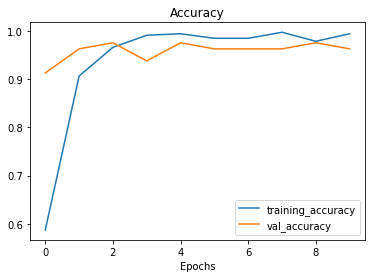

In [ ]:
plot_loss_curves(hist1)

In [ ]:
model1.evaluate(val_data)

5/5 [==============================] - 2s 407ms/step - loss: 0.1288 - accuracy: 0.9625


[0.12878181040287018, 0.9624999761581421]

In [ ]:
model1_results = calculate_results(val_data, model1)
model1_results

,accuracy,precision,recall,f1
0,93.75,0.947917,0.9375,0.936869
1,93.75,0.953125,0.9375,0.931548
2,93.75,0.950000,0.9375,0.930556
3,100.00,1.000000,1.0000,1.000000
4,100.00,1.000000,1.0000,1.000000


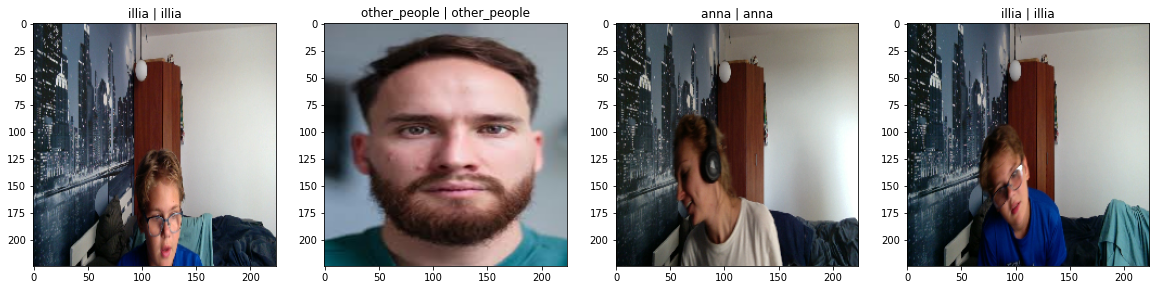

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i, img in enumerate(val_data.as_numpy_iterator()):
  if i == 4:
    break
  ax[i].imshow(img[0][0]/255)
  prediction = class_names[tf.argmax(model1.predict(tf.expand_dims(img[0][0],0)),1)[0]]
  ax[i].set_title(f"{class_names[tf.argmax(img[1][0],0)]} | {prediction}")